In [6]:
from __future__ import division

import pandas as pd
import re
import sklearn
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.metrics import mean_absolute_error as score_MAE
from sklearn.metrics import mean_squared_error as score_MSE 
from sklearn.metrics import median_absolute_error as score_MED
from sklearn.metrics import r2_score as score_R2
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.svm import SVR
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import *
import scipy.stats as stats
from datetime import datetime
import os.path

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold,RepeatedKFold,LeaveOneOut


%matplotlib inline



def load_data(metadata,datafile):

    meta = pd.read_csv(metadata)
    
    dfo = pd.read_csv(datafile, header=None)
    df = dfo.iloc[:,8:].T
    pdat = df.iloc[:,0].asobject

    uid = []
    ageType = []
    age = []
    source = []
    condition = []
    ethnicity = []
    gender = []
    
    for el in pdat:
        tid = el.split('_')[0]
        mdata = meta[meta['Tracking ID']==tid]
        uid.append(el)  
    
        x = mdata['Age'].iloc[0].lower()
        if 'fw' in x:
            ageType.append('fw') 
            m = re.search('\d{1,2} ?fw',x)
            age.append(int(m.group(0)[:-2]))
        elif 'nb' in x:
            ageType.append('nb')
            age.append(0)
        elif 'da' in x:
            ageType.append('nb')
            age.append(0)
        elif 'yr' in x:
            ageType.append('yr')
            m = re.search('\d{1,3} ?yr',x)
            # maybe use months sometime too, but not now
            # m2 = re.search('\d{1,2} ?mo',x) 
            age.append(int(m.group(0)[:-2]))
        else:
            print "OOOPS! " + x
                

        x = mdata['Condition'].iloc[0].lower()      
#        could be any of these types:
#                lab derived fibroblasts
#                normal
#                direct skin biopsy
#                control for hgps
#                relative of hgps
#                control for ism
#                ism
#                ism(sorted)
#                ism(hgps)
#                ism(relative of hgps)
#                heated direct skin biopsy
        condition.append(x)
        if 'fibroblast' in x:
            source.append('fibroblast')
        elif 'biopsy' in x:
            source.append('biopsy')
        else:
            source.append('coriell')
            
        gender.append( mdata['Gender'].iloc[0].lower() )
        ethnicity.append( mdata['Race/Ethnicity'].iloc[0].lower() )
   
            
            
    #
    #df = df.drop(0)
    #del df['patient data']
    #print len(ageType),len(age), len(condition), len(source), len(df)
    
    
    df.index = uid
    df.drop(df.columns[0],axis=1,inplace=True)
    df.columns = dfo.iloc[1:,0]
    trnum=[]
    for el in df.index:
        xx = el.split('_')[0]
        if xx=='pdl33': # get rid of the non-numeric tracking number which indicates #147 cells cultured to population doubling level 33
            trnum.append(33147)
        else:
            trnum.append(int(xx))
    df['tracking number'] = trnum
    df['ethnicity'] = ethnicity
    df['gender'] = gender
    df['source'] = source
    df['condition'] = condition
    df['age type'] = ageType
    df['age'] = age
    
    # rearrange so its easy to make a data matrix
    cols = df.columns.tolist()
    ncols = cols[-7:] + cols[:-7]
    df = df[ncols]   

    
    return df




alldata = load_data('MetaDataSheet.csv','fpkm.csv')


normals = (alldata.condition == 'normal') 
progeria = (alldata.condition == 'hgps')  
genes = alldata.iloc[:,7:].astype(float) # get only the gene expression levels, exclude the metadata
ages = alldata[normals].age 
age_prog = alldata[progeria].age


In [9]:
alldata[normals]

,tracking number,ethnicity,gender,source,condition,age type,age,NM_173803,NM_014423,NM_001103167,...,NR_029666,NM_080390,NM_001177675,NR_125786,NM_001291993,NM_021923,NM_017417,NM_004354,NR_024278,NM_145282
101_19yr_Female_Caucasian/ FPKM,101,caucasian,female,coriell,normal,yr,19,0.133,16.98,0.387,...,0,0,0,0,4.349,29.242,0.04,6.139,0.528,0
102_19yr_Male_Caucasian/ FPKM,102,caucasian,male,coriell,normal,yr,19,0.213,16.772,0.168,...,0,0,0,0,5.642,31.561,0,5.603,1.1,0
103_19yr_Male_Caucasian/ FPKM,103,caucasian,male,coriell,normal,yr,19,0.054,16.206,0.41,...,0,0.037,0,0,6.132,43.446,0,6.03,0.972,0
104_19yr_Male_Caucasian/ FPKM,104,caucasian,male,coriell,normal,yr,19,0.066,15.345,0.148,...,0,0,0.022,0,3.752,39.371,0,5.048,1.461,0
105_20yr_Male_Caucasian/ FPKM,105,caucasian,male,coriell,normal,yr,20,0.156,16.873,0.252,...,0,0.091,0,0,4.833,18.592,0,3.794,1.238,0
106_20yr_Female_Caucasian/ FPKM,106,caucasian,female,coriell,normal,yr,20,0.196,19.268,0.387,...,0,0.05,0,0,7.299,26.284,0,4.929,0.86,0
107_31yr_Female_Caucasian/ FPKM,107,caucasian,female,coriell,normal,yr,31,0.193,14.548,0.298,...,0,0.036,0.018,0,6.311,24.635,0,5.629,0.882,0
108_31_female_Caucasian/ FPKM,108,caucasian,female,coriell,normal,yr,31,0.149,21.798,0.252,...,0,0.051,0,0,8.245,23.805,0,9.283,0.91,0
109_32_male_Unknown/ FPKM,109,unknown,male,coriell,normal,yr,32,0.059,20.975,0.365,...,0,0,0,0,5.756,31.179,0,11.841,0.771,0
110_32_female_BlackPuertoRican/ FPKM,110,black/puerto rican,female,coriell,normal,yr,32,0.025,16.427,0.626,...,0,0,0.026,0,5.12,35.829,0,7.743,0.661,0


In [5]:
genes[normals]

,NM_173803,NM_014423,NM_001103167,NR_134623,NR_024490,NM_018397,NM_001037671,NR_106859,NM_133458,NM_001080424,...,NR_029666,NM_080390,NM_001177675,NR_125786,NM_001291993,NM_021923,NM_017417,NM_004354,NR_024278,NM_145282
101_19yr_Female_Caucasian/ FPKM,0.133,16.980,0.387,0.000,0.626,0.115,0.0,31.531,5.500,1.308,...,0.0,0.000,0.000,0.0,4.349,29.242,0.040,6.139,0.528,0.000
102_19yr_Male_Caucasian/ FPKM,0.213,16.772,0.168,0.000,0.701,0.077,0.0,27.992,6.473,1.357,...,0.0,0.000,0.000,0.0,5.642,31.561,0.000,5.603,1.100,0.000
103_19yr_Male_Caucasian/ FPKM,0.054,16.206,0.410,0.000,1.135,0.284,0.0,25.915,6.770,1.495,...,0.0,0.037,0.000,0.0,6.132,43.446,0.000,6.030,0.972,0.000
104_19yr_Male_Caucasian/ FPKM,0.066,15.345,0.148,0.000,0.685,0.304,0.0,18.776,5.773,1.688,...,0.0,0.000,0.022,0.0,3.752,39.371,0.000,5.048,1.461,0.000
105_20yr_Male_Caucasian/ FPKM,0.156,16.873,0.252,0.090,0.806,0.094,0.0,18.481,5.052,1.384,...,0.0,0.091,0.000,0.0,4.833,18.592,0.000,3.794,1.238,0.000
106_20yr_Female_Caucasian/ FPKM,0.196,19.268,0.387,0.000,0.687,0.118,0.0,28.714,6.436,2.036,...,0.0,0.050,0.000,0.0,7.299,26.284,0.000,4.929,0.860,0.000
107_31yr_Female_Caucasian/ FPKM,0.193,14.548,0.298,0.000,1.291,0.276,0.0,28.669,5.528,2.050,...,0.0,0.036,0.018,0.0,6.311,24.635,0.000,5.629,0.882,0.000
108_31_female_Caucasian/ FPKM,0.149,21.798,0.252,0.000,1.367,0.090,0.0,32.658,4.541,1.451,...,0.0,0.051,0.000,0.0,8.245,23.805,0.000,9.283,0.910,0.000
109_32_male_Unknown/ FPKM,0.059,20.975,0.365,0.000,1.237,0.071,0.0,21.850,4.512,1.207,...,0.0,0.000,0.000,0.0,5.756,31.179,0.000,11.841,0.771,0.000
110_32_female_BlackPuertoRican/ FPKM,0.025,16.427,0.626,0.000,1.101,0.365,0.0,27.374,4.923,1.236,...,0.0,0.000,0.026,0.0,5.120,35.829,0.000,7.743,0.661,0.000


In [13]:

class subset_genes_LinRegr(LinearRegression):
    
    def __init__(self, fit_intercept=True, normalize=False, copy_X=True,
                     n_jobs=1, subset_min=0, subset_fold=0, subset_logT=False, convfpkmToTpm=False, verbose=False):
            self.subset_min = subset_min
            self.subset_fold = subset_fold
            self.subset_logT = subset_logT
            self.convfpkmToTpm = convfpkmToTpm
            self.verbose = verbose

            super(subset_genes_LinRegr, self).__init__(
                    fit_intercept=fit_intercept, normalize=normalize, copy_X=copy_X, n_jobs=n_jobs )
        
        
    def _expr_levels(self, data,logTrans=False):
        if logTrans:
            return np.log2(data + 1)
        else:
            return data
        
    # this version of subset genes assumes data is ONLY genes with no metadata columns in a pd.DataFrame 
    def _subset_genes(self, data, verbose=False, these_genes=np.array(False) ):
        if these_genes.any(): # just get these_genes
            genes = self._expr_levels(data,logTrans=self.subset_logT)      
        else: # calculate the these_genes list based on the other parameters    
            
            genes = self._expr_levels(data,logTrans=False)  # operate selection criteria on non-log FPKM
            eps = 0.001
            has_start_gt = genes > self.subset_min
            mvt = genes.min()
            mvt[ mvt<eps ] = eps
            has_fold_change = (genes.max() / mvt)  > self.subset_fold
            
            aset = (has_start_gt.any(axis=0) & has_fold_change)
            these_genes = aset[ aset ].index # get list of gene names that meet criteria
            genes = self._expr_levels(data,logTrans=self.subset_logT) # do the final op on user-selected xform
            
        subgenes = genes.loc[:,these_genes]        
        if verbose:
            print 'using {} genes in subset requiring a max FPKM > {} and > {}fold change between max and min samples '.format(len(these_genes), self.subset_min, self.subset_fold)

        return subgenes

        

    def predict(self, X):
        """Perform regression on samples in X.
        For an one-class model, +1 (inlier) or -1 (outlier) is returned.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            For kernel="precomputed", the expected shape of X is
            (n_samples_test, n_samples_train).
        Returns
        -------
        y_pred : array, shape (n_samples,)
        """
        check_is_fitted(self, 'genecolumns_')
        X_sub = self._subset_genes(X, these_genes=self.genecolumns_)
        #X_sub = super(subset_genes_LinRegr, self)._validate_for_predict(X_sub)
        return super(subset_genes_LinRegr, self).predict(X_sub)
    
    def fit(self, X, y, sample_weight=None):
        check_is_fitted(self, 'subset_min')
        check_is_fitted(self, 'subset_fold')
        check_is_fitted(self, 'subset_logT')
        X_sub = self._subset_genes(X, verbose=self.verbose)
        self.genecolumns_ = X_sub.columns
        super(subset_genes_LinRegr, self).fit(X_sub, y, sample_weight)
        return self
        

In [14]:

class subset_genes_ElasticNet(ElasticNet):
    
    def __init__(self, alpha=1.0, l1_ratio=0.5, fit_intercept=True,
                 normalize=False, precompute=False, max_iter=1000,
                 copy_X=True, tol=1e-4, warm_start=False, positive=False,
                 random_state=None, selection='cyclic', 
                 subset_min=0, subset_fold=0, subset_logT=False, convfpkmToTpm=False, verbose=False):
            self.subset_min = subset_min
            self.subset_fold = subset_fold
            self.subset_logT = subset_logT
            self.convfpkmToTpm = convfpkmToTpm
            self.verbose = verbose

            super(subset_genes_ElasticNet, self).__init__(
                 alpha=alpha, l1_ratio=l1_ratio, fit_intercept=fit_intercept,
                 normalize=normalize, precompute=precompute, max_iter=max_iter,
                 copy_X=copy_X, tol=tol, warm_start=warm_start, positive=positive,
                 random_state=random_state, selection=selection )
            
    def _expr_levels(self, data,logTrans=False):
        if logTrans:
            return np.log2(data + 1)
        else:
            return data
        
    # this version of subset genes assumes data is ONLY genes with no metadata columns in a pd.DataFrame 
    def _subset_genes(self, data, verbose=False, these_genes=np.array(False) ):
        if these_genes.any(): # just get these_genes
            genes = self._expr_levels(data,logTrans=self.subset_logT)      
        else: # calculate the these_genes list based on the other parameters    
            
            genes = self._expr_levels(data,logTrans=False)  # operate selection criteria on non-log FPKM
            eps = 0.001
            has_start_gt = genes > self.subset_min
            mvt = genes.min()
            mvt[ mvt<eps ] = eps
            has_fold_change = (genes.max() / mvt)  > self.subset_fold
            
            aset = (has_start_gt.any(axis=0) & has_fold_change)
            these_genes = aset[ aset ].index # get list of gene names that meet criteria
            genes = self._expr_levels(data,logTrans=self.subset_logT) # do the final op on user-selected xform
            
        subgenes = genes.loc[:,these_genes]        
        if verbose:
            print 'using {} genes in subset requiring a max FPKM > {} and > {}fold change between max and min samples '.format(len(these_genes), self.subset_min, self.subset_fold)

        return subgenes

        

    def predict(self, X):
        """Perform regression on samples in X.
        For an one-class model, +1 (inlier) or -1 (outlier) is returned.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            For kernel="precomputed", the expected shape of X is
            (n_samples_test, n_samples_train).
        Returns
        -------
        y_pred : array, shape (n_samples,)
        """
        check_is_fitted(self, 'genecolumns_')
        X_sub = self._subset_genes(X, these_genes=self.genecolumns_)
        #X_sub = super(subset_genes_LinRegr, self)._validate_for_predict(X_sub)
        return super(subset_genes_ElasticNet, self).predict(X_sub)
    
    def fit(self, X, y, check_input=True):
        check_is_fitted(self, 'subset_min')
        check_is_fitted(self, 'subset_fold')
        check_is_fitted(self, 'subset_logT')
        check_is_fitted(self, 'convfpkmToTpm')
        X_sub = self._subset_genes(X, verbose=self.verbose)
        self.genecolumns_ = X_sub.columns
        super(subset_genes_ElasticNet, self).fit(X_sub, y, check_input)
        return self
        

In [15]:

class subset_genes_SVR(SVR):
    
    def __init__(self, kernel='rbf', degree=3, gamma='auto', coef0=0.0,
                 tol=1e-3, C=1.0, epsilon=0.1, shrinking=True,
                 cache_size=200, verbose=False, max_iter=-1,
                 subset_min=0, subset_fold=0, subset_logT=False):
        self.subset_min = subset_min
        self.subset_fold = subset_fold
        self.subset_logT = subset_logT

        super(subset_genes_SVR, self).__init__(
            kernel=kernel, degree=degree, gamma=gamma,
            coef0=coef0, tol=tol, C=C, epsilon=epsilon, verbose=verbose,
            shrinking=shrinking, cache_size=cache_size, max_iter=max_iter)
        
        
    def _expr_levels(self, data,logTrans=False):
        if logTrans:
            return np.log2(data + 1)
        else:
            return data
        
    # this version of subset genes assumes data is ONLY genes with no metadata columns in a pd.DataFrame 
    def _subset_genes(self, data, verbose=False, these_genes=np.array(False) ):
        if these_genes.any(): # just get these_genes
            genes = self._expr_levels(data,logTrans=self.subset_logT)      
        else: # calculate the these_genes list based on the other parameters    
            
            genes = self._expr_levels(data,logTrans=False)  # operate selection criteria on non-log FPKM
            eps = 0.001
            has_start_gt = genes > self.subset_min
            mvt = genes.min()
            mvt[ mvt<eps ] = eps
            has_fold_change = (genes.max() / mvt)  > self.subset_fold
            
            aset = (has_start_gt.any(axis=0) & has_fold_change)
            these_genes = aset[ aset ].index # get list of gene names that meet criteria
            genes = self._expr_levels(data,logTrans=self.subset_logT) # do the final op on user-selected xform
            
        subgenes = genes.loc[:,these_genes]        
        if verbose:
            print 'using {} genes in subset requiring a max FPKM > {} and > {}fold change between max and min samples '.format(len(these_genes), self.subset_min, self.subset_fold)

        return subgenes
        

    def predict(self, X):
        """Perform regression on samples in X.
        For an one-class model, +1 (inlier) or -1 (outlier) is returned.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            For kernel="precomputed", the expected shape of X is
            (n_samples_test, n_samples_train).
        Returns
        -------
        y_pred : array, shape (n_samples,)
        """
        check_is_fitted(self, 'genecolumns_')
        X_sub = self._subset_genes(X, these_genes=self.genecolumns_)
        X_sub = super(subset_genes_SVR, self)._validate_for_predict(X_sub)
        predict = self._sparse_predict if self._sparse else self._dense_predict
        return predict(X_sub)
    
    def fit(self, X, y, sample_weight=None):
        check_is_fitted(self, 'subset_min')
        check_is_fitted(self, 'subset_fold')
        check_is_fitted(self, 'subset_logT')
        X_sub = self._subset_genes(X, verbose=self.verbose)
        self.genecolumns_ = X_sub.columns
        super(subset_genes_SVR, self).fit(X_sub, y, sample_weight)
        return self
        

In [68]:

class subset_genes_ensemble(BaseEstimator, ClassifierMixin):
    
    def __init__(self, clf=None, class_size=20, subset_min=0, subset_fold=0, subset_logT=False, verbose=False):
            self.subset_min = subset_min
            self.subset_fold = subset_fold
            self.subset_logT = subset_logT
            self.clf = clf
            self.class_size = class_size
            self.verbose = verbose

            
        
    def _expr_levels(self, data,logTrans=False):
        if logTrans:
            return np.log2(data + 1)
        else:
            return data
        
    # this version of subset genes assumes data is ONLY genes with no metadata columns in a pd.DataFrame 
    def _subset_genes(self, data, verbose=False, these_genes=np.array(False) ):
        if these_genes.any(): # just get these_genes
            genes = self._expr_levels(data,logTrans=self.subset_logT)      
        else: # calculate the these_genes list based on the other parameters    
            
            genes = self._expr_levels(data,logTrans=False)  # operate selection criteria on non-log FPKM
            eps = 0.001
            has_start_gt = genes > self.subset_min
            mvt = genes.min()
            mvt[ mvt<eps ] = eps
            has_fold_change = (genes.max() / mvt)  > self.subset_fold
            
            aset = (has_start_gt.any(axis=0) & has_fold_change)
            these_genes = aset[ aset ].index # get list of gene names that meet criteria
            genes = self._expr_levels(data,logTrans=self.subset_logT) # do the final op on user-selected xform
            
        subgenes = genes.loc[:,these_genes]        
        if verbose:
            print 'using {} genes in subset requiring a max FPKM > {} and > {}fold change between max and min samples '.format(len(these_genes), self.subset_min, self.subset_fold)

        return subgenes
    
    def _get_bounds(self, minimum,maximum,offset,interval):

        done = False;
        lower = minimum;
        while (not done):
            if (lower==minimum):
                if (offset>0):
                    upper = lower+offset;
                else:
                    upper = lower+interval;

                bounds = np.array([[lower,upper-1]]);
                lower = upper;
                continue;
            else:
                upper = min(lower+interval,maximum+1);

            done = upper>maximum;
            bounds = np.append(bounds,[[lower,upper-1]],axis=0);

            lower = upper;
        return bounds;
    
    def _predict_age(self, train_feat, train_age, test_feat, class_size, clf):
        n_samp = len(train_age);
        age_min = min(train_age);
        age_max = max(train_age);

        votes = []
        for _ in range(test_feat.shape[0]): # make a votes list of lists as long as the number of test samples
            votes.append([])

        # For each partition
        for offset in range(0,class_size):    
            bounds = self._get_bounds(age_min,age_max,offset,class_size);
            n_classes = len(bounds);
            train_class = np.empty(n_samp,dtype=object);
            class_names = np.empty(n_classes,dtype=object)

            for i in range(0,n_classes):
                lower = bounds[i][0];
                upper = bounds[i][1];
                class_names[i] = str(lower) + '-' + str(upper);
                in_class = np.logical_and(train_age>=lower,train_age<=upper);
                train_class[in_class] = class_names[i];

            # Train
            clf.fit(train_feat,train_class);
            self.classifiers_.append(clf)

            # Predict an age class for the current sample
            predictions = clf.predict(test_feat);

            """        
            Each vote for age i is stored as an single instance of integer i 
            (i.e. by analogy, a slip with the age is placed in a ballot box) 
            so that the mean and median predicted age can be taken in addition to 
            or instead of the mode.
            """
            for k, class_predict in enumerate(predictions):
                
                # Generate constituent integer ages from the predicted age class
                bnd_predict = bounds[class_names == class_predict][0];
                this_vote = np.arange(bnd_predict[0],bnd_predict[1]+1,1);

                # Store predicted integer ages
                votes[k] = np.append(votes[k],this_vote);

        # Take the mode (or median or mean or some more elaborate voting scheme if you like) integer predicted age
        # as the final predicted age
        age_predict = [ stats.mode(vs).mode[0] for vs in votes]

        return (age_predict, votes)

    
    def predict(self, X):
        check_is_fitted(self, 'genecolumns_')
        check_is_fitted(self, 'train_data_')
        check_is_fitted(self, 'train_label_')
        X_sub = self._subset_genes(X, these_genes=self.genecolumns_)
        pred, votes =  self._predict_age(self.train_data_, self.train_label_, X_sub, self.class_size, self.clf)
        self.votes_ = votes
        return pred
    
    def fit(self, X, y):
        check_is_fitted(self, 'subset_min')
        check_is_fitted(self, 'subset_fold')
        check_is_fitted(self, 'subset_logT')
        X_sub = self._subset_genes(X, verbose=True)
        self.genecolumns_ = X_sub.columns
        self.train_data_ = X_sub
        self.train_label_ = y
        self.classifiers_ = []
        # do nothing except store variables... predict_age does both fit_ & predict
        return self
    



In [54]:
def estimate_accuracy_gained_persample(clf, gene_data, age_labels, metric, crossval, n_jobs):
     
    lc_sizes = [60, 75, 90, 105, 119] # 119 not 120 because small variations in fold generation can cause us to run out of samples at 120
    scorer = sklearn.metrics.make_scorer(metric)
    tsizes, train_score, test_score = sklearn.model_selection.learning_curve(
            clf, gene_data, age_labels, train_sizes=lc_sizes, cv = crossval, 
            scoring=scorer, n_jobs = njobs, pre_dispatch = 2*njobs, shuffle=False, verbose=2)
    size_labels = np.repeat(tsizes,test_score.shape[1])
    learning_curve = pd.DataFrame( { 
        'Test set {}'.format(scorer._score_func.func_name):
            np.reshape(test_score,[np.prod(test_score.shape),]),
        'Training set {}'.format(scorer._score_func.func_name):
            np.reshape(train_score,[np.prod(train_score.shape),]),
        'Training set size':size_labels} )
    #sns.lmplot(data=learning_curve, x='Training set size',
    #       y='Test set {}'.format(scorer._score_func.func_name))
    return learning_curve





In [270]:
def make_figs( name,  model=False, search_cval=False, parameters=None, plot_cval=False, lcurve_cval=False, njobs=1):

    # makes use of global variables: normals, progeria, genes, ages, etc...
    
    if search_cval:
        print "grid searching..."
        clfcv = GridSearchCV(model, parameters, cv=search_cval, n_jobs=njobs, pre_dispatch=2*njobs, scoring='neg_mean_absolute_error', verbose=2)
        clfcv.fit( genes[normals], ages)
        clf = clfcv.best_estimator_
        dump(clfcv.cv_results_,'saved_fig2_output/fig2_searchresults_{}.pkl'.format(name))
        dump(clf,'saved_fig2_output/fig2_bestmodel_{}.pkl'.format(name))
    else: #
        if model: # no search, just use model in the case of parameterless algortihms like linear regression
            clf = model
        else: # load up a previously saved model
            clf = load('saved_fig2_output/fig2_bestmodel_{}.pkl'.format(name))
    
    print "Using ",clf
        
    if plot_cval:
        print "LOOCV...", clf
        true_age = []
        pred_age = []
        for train, test in plot_cval.split(genes[normals]):
            clf.fit(genes[normals].iloc[train,:],ages[train])
            pred_age.append( clf.predict(genes[normals].iloc[test,:]) )
            true_age.append( ages[test] )
        pred_age = np.array(pred_age).flatten() 
        true_age = np.array(true_age).flatten()
        
        clf.fit(genes[normals],ages)
        prog_predict = clf.predict(genes[progeria])
        np.save('saved_fig2_output/fig2_pred_age_{}.npy'.format(name),pred_age)
        np.save('saved_fig2_output/fig2_true_age_{}.npy'.format(name),true_age)
        np.save('saved_fig2_output/fig2_pred_prog_age_{}.npy'.format(name),prog_predict)
        dump(clf,'saved_fig2_output/fig2_modelafterloocv_{}.pkl'.format(name))
        # don't need to save true progeria age because there's no way for it to be order permuted by a cross-validator
    else:
        pred_age = np.load('saved_fig2_output/fig2_pred_age_{}.npy'.format(name))
        true_age = np.load('saved_fig2_output/fig2_true_age_{}.npy'.format(name))
        prog_predict = np.load('saved_fig2_output/fig2_pred_prog_age_{}.npy'.format(name))
        #clf = load('saved_fig2_output/fig2_modelafterloocv_{}.pkl'.format(name))

              
    if lcurve_cval:
        print "learning curve..."
        lcurve = estimate_accuracy_gained_persample(clf, genes[normals], ages, score_MAE, lcurve_cval, njobs)
        lcurve['Mean absolute error'] = lcurve['Test set mean_absolute_error']
        lcurve.to_csv('saved_fig2_output/lcurve_{}.csv'.format(name))
    else:
        lcurve = pd.read_csv('saved_fig2_output/lcurve_{}.csv'.format(name))
              

    #errstr = "{} MAE:{:3.2f} MED:{:3.2f} R2:{:3.2f}".format( name, score_MAE(true_age,pred_age), score_MED(true_age,pred_age), score_R2(true_age,pred_age))
    errstr = "MAE:{:3.1f} MED:{:3.1f} R2:{:3.2f}".format( score_MAE(true_age,pred_age), score_MED(true_age,pred_age), score_R2(true_age,pred_age)) 

    sns.set_style('white')
    sns.set_palette( sns.xkcd_palette(['nice blue','faded red']))
    
    fig1 = plt.figure(figsize=(3.5,3.5));
    ax1 = fig1.add_subplot(111);
    sns.regplot(true_age,pred_age, ax=ax1)
    ax1.plot([0,100],[0,100],'k:')
    ax1.text(0.99, 0.03, errstr,
            horizontalalignment='right',
            verticalalignment='bottom',
            transform=ax1.transAxes)
    #plt.title(name)
    plt.axis('equal')
    ax1.set_xlabel('True age (years)'), ax1.set_ylabel('Predicted age (years)');
    sns.despine()
    plt.tight_layout()
    plt.draw()
    plt.savefig('saved_fig2_output/fig2_plot_predictions_{}.png'.format(name),dpi=400)
    print "LOOCV ", name, errstr

    fig2 = plt.figure(figsize=(3.5,3.5));
    ax2 = fig2.add_subplot(111);
    # we had to use 119 to avoid a kfold issue, but aesthestically I want it to show 120 so the progression of set size is even
    lcurve.loc[ lcurve['Training set size']==119, 'Training set size' ] = 120
    sns.regplot(data=lcurve, x='Training set size', y='Mean absolute error', ax=ax2)
    #sns.boxplot(data=lcurve, x='Training set size', y='Mean absolute error', color='white', ax=ax2)
    #plt.title(name)
    plt.ylim([0,30])
    #plt.xlim([50,130])
    sns.despine()
    plt.tight_layout()
    plt.draw()
    plt.savefig('saved_fig2_output/fig2_plot_learning_curve_{}.png'.format(name),dpi=400)
    
    fig3 = plt.figure(figsize=(3.5,3.5));
    ax3 = fig3.add_subplot(111);
    these = (true_age < 10)
    sns.regplot(true_age[these],pred_age[these],ax=ax3,label='Controls',fit_reg=False)#,color='xkcd:nice blue')
    sns.regplot(age_prog,np.array(prog_predict),ax=ax3,label='Progeria',fit_reg=False)#,color='xkcd:faded red')
    #plt.title(name)
    ax3.plot([0,10],[0,10],'k:')
    plt.ylim([-15,40])
    plt.xlabel('True age (years)')
    plt.ylabel('Predicted age (years)')
    leg=plt.legend(frameon=True)
    leg.get_frame().set_facecolor('xkcd:light gray')
    plt.tight_layout()
    sns.despine()
    plt.draw()
    plt.savefig('saved_fig2_output/fig2_plot_progeria{}.png'.format(name),dpi=400)
    
    fig4 = plt.figure(figsize=(3.5,3.5));
    ax4 = fig4.add_subplot(111);
    these = (true_age < 10)
    toplot = pd.DataFrame({'True age (years)':np.hstack([true_age[these],age_prog]), 
                           'Predicted age (years)':np.hstack([pred_age[these],prog_predict]),
                           'Sample':np.hstack([['Controls' for el in true_age[these]], ['Progeria' for el in age_prog]])
                          })
    sns.boxplot(data=toplot, y='Predicted age (years)', x='Sample', ax=ax4)
    v1 = toplot.loc[toplot.Sample=='Progeria','Predicted age (years)']
    v2 = toplot.loc[toplot.Sample=='Controls','Predicted age (years)']
    ts, pv = stats.ttest_ind(v1,v2)
    pstr = 'Diff of means: {:.2e}\nStudent\'s t={:.2e}, p={:.2e}'.format( v1.mean() - v2.mean(), ts, pv)
    ax4.text(0.99, 0.03, pstr,
            horizontalalignment='right',
            verticalalignment='bottom',
            transform=ax4.transAxes)
    #plt.title(name)
    #ax3.plot([0,10],[0,10],'k:')
    plt.ylim([-15,40])
    plt.xlabel('')
    #plt.ylabel('Predicted age (years)')
    plt.tight_layout()
    sns.despine(right=True,top=True,bottom=True)
    plt.draw()
    plt.savefig('saved_fig2_output/fig2_plot_progeria_box{}.png'.format(name),dpi=400)
    
    return clf
  

Using  subset_genes_ElasticNet(alpha=0.1, convfpkmToTpm=False, copy_X=True,
            fit_intercept=True, l1_ratio=0.0, max_iter=1000,
            normalize=False, positive=False, precompute=False,
            random_state=None, selection='cyclic', subset_fold=5,
            subset_logT=True, subset_min=5, tol=0.0001, verbose=False,
            warm_start=False)
LOOCV  Elastic net MAE:12.0 MED:11.0 R2:0.73


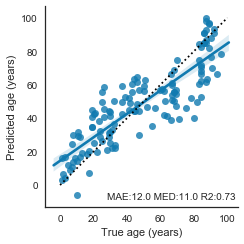

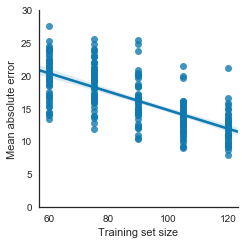

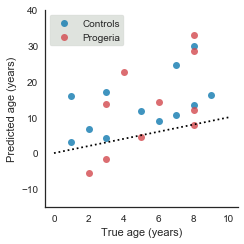

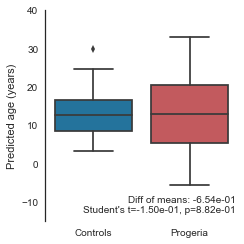

In [271]:

njobs = 20 # set this according to the number of available cores on your machine

search_cval = RepeatedKFold(n_repeats=2, n_splits=10)
lcurve_cval = RepeatedKFold(n_repeats=5, n_splits=10) 

subelast = False # subset_genes_ElasticNet()
parameters = { 'l1_ratio':np.arange(0.,1.1,0.1), 'alpha':np.arange(0.1,1.1,0.1), 'subset_min':[5], 'subset_fold':[5], 'subset_logT':[True]}

elastregr = make_figs( 'Elastic net', model=subelast, 
                  #search_cval=search_cval, parameters=parameters, # uncomment these lines
                  #plot_cval=LeaveOneOut(),                        # to rerun the analysis from scratch 
                  #lcurve_cval=lcurve_cval,                        # instead of loading results from disk
                  njobs=njobs)                                      

Using  subset_genes_SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
         gamma='auto', kernel='rbf', max_iter=-1, shrinking=True,
         subset_fold=0, subset_logT=False, subset_min=0, tol=0.001,
         verbose=False)
LOOCV  Support vector regression MAE:11.9 MED:10.2 R2:0.72


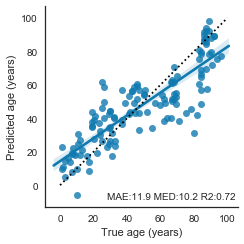

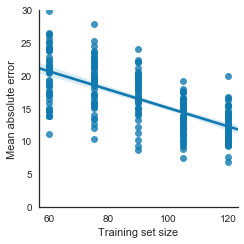

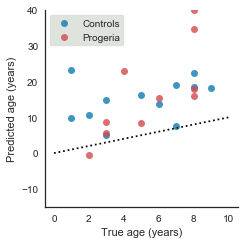

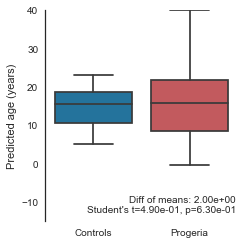

In [272]:

njobs = 20 # set this according to the number of available cores on your machine

search_cval = RepeatedKFold(n_repeats=2, n_splits=10)
lcurve_cval = RepeatedKFold(n_repeats=5, n_splits=10) 

subsvr = subset_genes_SVR()
parameters = { 'kernel':['poly'], 'epsilon':[0.05, 0.1, 0.5, 1.0, 2.0], 'subset_min':[5], 'subset_fold':[5], 'subset_logT':[True], 'C':[1, 5, 10, 50, 100, 500, 1000, 5000],  'degree':[2,3], 'gamma':[1.0/10000, 1.0/5000, 1.0/1000, 1.0/500, 1.0/100, 1.0/50]}

svregr = make_figs( 'Support vector regression', model=subsvr, 
                  #search_cval=search_cval, parameters=parameters, # uncomment these lines
                  #plot_cval=LeaveOneOut(),                        # to rerun the analysis from scratch 
                  #lcurve_cval=lcurve_cval,                        # instead of loading results from disk
                  njobs=njobs)          

Using  subset_genes_LinRegr(convfpkmToTpm=False, copy_X=True, fit_intercept=True,
           n_jobs=1, normalize=False, subset_fold=5, subset_logT=True,
           subset_min=5, verbose=False)
LOOCV  Linear regression MAE:12.1 MED:10.0 R2:0.73


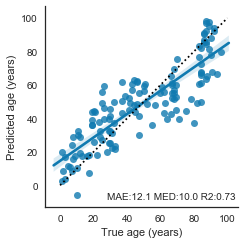

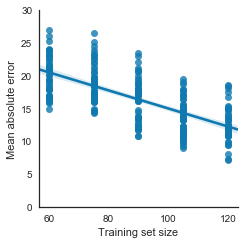

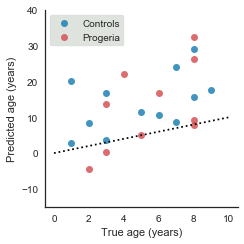

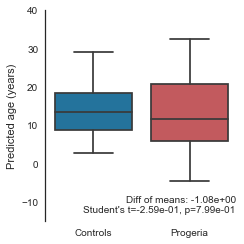

In [273]:

njobs = 20 # set this according to the number of available cores on your machine

search_cval = RepeatedKFold(n_repeats=2, n_splits=10)
lcurve_cval = RepeatedKFold(n_repeats=5, n_splits=10) 

sublin = subset_genes_LinRegr(subset_fold=5,subset_min=5,subset_logT=True)

linregr = make_figs( 'Linear regression', model=sublin, 
                  # no gridsearch since linear regr has no parameters! # uncomment these lines
                  #plot_cval=LeaveOneOut(),                        # to rerun the analysis from scratch 
                  #lcurve_cval=lcurve_cval,                        # instead of loading results from disk
                  njobs=njobs)          

Using  subset_genes_ensemble(class_size=20,
           clf=LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage='auto',
              solver='eigen', store_covariance=False, tol=0.0001),
           subset_fold=5, subset_logT=True, subset_min=5, verbose=False)
LOOCV  Ensemble LDA MAE:7.7 MED:4.0 R2:0.81


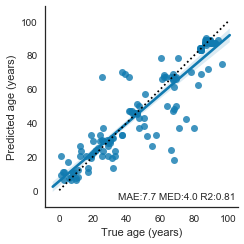

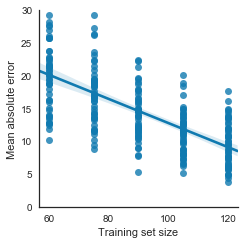

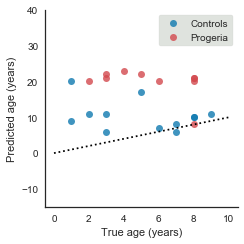

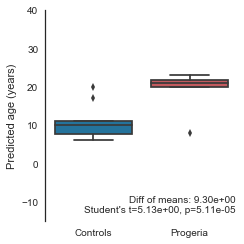

In [275]:
# this will take a really really long time to run... 
# like on the order of a week or several weeks, depending on your computer!
# The eigen solver for LDA uses scipy to calculate eigenmatrices 
# to get the the ratio of between class scatter to within class scatter 
# ... and this is slow because these are huge matrices!
# By slow I mean on the order of a minute per eigen solution, but when multiplied
# by the large number of validation folds and members of the ensemble... its a long time.
# Running this on a machine with 64 2.3Ghz CPUs (E5 Xeon) & 256GB RAM
# where on average it was able to utilize ~40% of the CPU cycles available
# resulted in a run that lasted 4 days, 18 hours

# sklearn/scipy uses LAPACK to do the linear algebra 
# and LAPACK has its own multithreading inside it 
# therefore it is counter-productive to start more than one job at the level of sklearn
njobs = 1 

search_cval = RepeatedKFold(n_repeats=2, n_splits=10)
lcurve_cval = RepeatedKFold(n_repeats=5, n_splits=10) 

clf = LinearDiscriminantAnalysis(shrinkage='auto',solver='eigen')
ensemble = subset_genes_ensemble(clf=clf, class_size=20, subset_fold=5,subset_min=5,subset_logT=True)
parameters = {'class_size':[30, 20, 10], 'subset_min':[5], 'subset_fold':[5], 'subset_logT':[True] }

#print "started at {}".format(datetime.now())
ensembleLDA = make_figs( 'Ensemble LDA', model=ensemble, 
#                  search_cval=search_cval, parameters=parameters, # uncomment these lines
#                  plot_cval=LeaveOneOut(),                        # to rerun the analysis from scratch 
#                  lcurve_cval=lcurve_cval,                        # instead of loading results from disk
                  njobs=njobs)

#print "finished at {}".format(datetime.now())

In [235]:
lc = pd.read_csv('lcurve_Ensemble LDA.csv')
lc

,Unnamed: 0,Test set mean_absolute_error,Training set mean_absolute_error,Training set size,Mean absolute error
0,0,26.071429,0.0,60,26.071429
1,1,27.500000,0.0,60,27.500000
2,2,22.785714,0.0,60,22.785714
3,3,16.000000,0.0,60,16.000000
4,4,25.769231,0.0,60,25.769231
5,5,19.923077,0.0,60,19.923077
6,6,19.384615,0.0,60,19.384615
7,7,17.230769,0.0,60,17.230769
8,8,10.153846,0.0,60,10.153846
9,9,29.153846,0.0,60,29.153846


In [236]:
from scipy.stats import linregress
x=lc['Training set size']
y=lc['Mean absolute error']
slope, intercept, r_value, p_value, std_err = linregress(x, y)

In [237]:
slope, intercept, r_value, p_value, std_err, r_value**2

(-0.18657343295740217,
 31.352294279574714,
 -0.6646014773840927,
 3.101718402348752e-33,
 0.013319820442234183,
 0.4416951237411187)

In [240]:
from scipy.stats import theilslopes
res = stats.theilslopes(y, x, 0.95)
res

(-0.1794871794871795,
 29.818681318681318,
 -0.20689655172413793,
 -0.15384615384615366)

In [257]:
(5 - 7.7 )/ (-.15) # truncate 95% ci lower bound to 2 significant figures

18.000000000000004

In [258]:
(3 - 7.7 )/ (-.15)

31.333333333333336